#EEG Tabular Learner with fast.ai v2 and wandb
This is a test project I am using to learn fastai v2 for structured data. I am using data from a past Kaggle competition to train a model that can detect certain events from EEG brainwave data. The events would then trigger certain gestures in a prosthetic device for example. My goal is to get perfect/near perfect predictions on the testing data. You can get more info on the contest/dataset [here](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/)

## **Install The Libraries**
First we install install all necessary Python libraries with pip.

In [8]:
%pip install git+https://github.com/fastai/fastcore.git -q
%pip install git+https://github.com/fastai/fastai2.git -q

In [0]:
!pip install wandb
!pip install kaggle

## **Kaggle Environment Setup**
You will need to upload your *kaggle.json*, set the permissions so the file can be read.

In [0]:
!chmod 600 ./kaggle.json

Then we set the Kaggle configuration directory to our current working directory, as an environment variable.

In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

Now we can download the data from the competition page, 

In [6]:
!kaggle competitions download grasp-and-lift-eeg-detection -f train.zip

100% 912M/915M [00:13<00:00, 98.3MB/s]
100% 915M/915M [00:13<00:00, 68.7MB/s]


and unzip it into the data directory.

In [0]:
!unzip train.zip -d data/

## **Data Setup**
First let's import all the libraries we need.

In [0]:
from fastai2.data.all import *
from fastai2.tabular.all import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *
import pandas as pd
import numpy as np

Next we specify the path of our training data. Then we're specifying the types of our features and labels, because otherwise pandas will use a lot of memory storing them. 

The training data is separated into files representing 10 test subjects and 8 series per subject. And the files with our labels have a suffix of `events` attached to them. 
* The `load_one_series` function takes a specific series of a subject, and merges it with the labels from the corresponding `events` csv.
* The `get_merged_series` function takes the nth series(the function parameter) 
from every subject, and merges them into one dataframe using the `load_one_series` function. We're going to use this for our validation set.

In [0]:
path = './data/train'

feature_types = {
    'Id': 'str', 'Fp1': 'int16', 'Fp2': 'int16', 'F7': 'int16', 'F3': 'int16', 'Fz': 'int16',
    'F4': 'int16', 'F8': 'int16', 'FC5': 'int16', 'FC1': 'int16', 'FC2': 'int16', 'FC6': 'int16',
    'T7': 'int16', 'C3': 'int16', 'Cz': 'int16', 'C4': 'int16', 'T8': 'int16', 'TP9': 'int16',
    'CP5': 'int16', 'CP1': 'int16', 'CP2': 'int16', 'CP6': 'int16', 'TP10': 'int16', 'P7': 'int16',
    'P3': 'int16', 'Pz': 'int16', 'P4': 'int16', 'P8': 'int16', 'PO9': 'int16', 'O1': 'int16',
    'Oz': 'int16', 'O2': 'int16', 'PO10': 'int16'
}

label_types = {
    'Id': 'str', 'HandStart': 'int8', 'FirstDigitTouch': 'int8', 'LiftOff': 'int8', 
    'Replace': 'int8', 'BothReleased': 'int8'
}

def load_one_series(sj, sr):
  df = pd.read_csv(f'{path}/subj{sj}_series{sr}_data.csv', dtype=feature_types)
  labels = pd.read_csv(f'{path}/subj{sj}_series{sr}_events.csv', dtype=label_types)
  keys = labels.keys()
  for id in range(0, len(df.index)):
    df.loc[id, 'Labels'] = 'None'
    nl = '\n'
    log = f"Rows left to label: {len(df.index) - id}...{nl}"
    print(log)
    for col in keys:
      if labels.at[id, col] == 1:
        df.loc[id, 'Labels'] = col
        break
  return df

def get_merged_series(sr):
  df = None
  for sj in range(1, 13):
    temp = load_one_series(sj, sr)
    df = temp if df is None else df.append(temp)
  return df

Creating the validation set will take some time as these files are quite large. Make some coffee =). But once it's done we can save it locally to load faster in the future. So you should only need to do this once.  

In [0]:
valid = get_merged_series(8)

In [0]:
valid.to_csv('valid.csv', index=False)

Here we load in our validation data.

In [0]:
valid = pd.read_csv('valid.csv')

Then we generate our first training set.

In [0]:
train = load_one_series(1, 1)

**SKIP THIS STEP PROBABLY!** This is a way to remove the extra indexing column we don't need. Shouldn't need to run this line if we saved with `index=False` from the beginning.

In [0]:
train = train.loc[:, ~train.columns.str.match('id')]

In [0]:
valid = valid.loc[:, ~valid.columns.str.match('id')]

We can check here to make sure our data is organized as expected.

In [0]:
train.tail()

In [19]:
valid.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,Labels
0,-225,-142,313,211,-61,508,270,542,57,-66,344,-222,397,42,300,-317,-585,-6,155,155,132,-167,149,118,154,266,473,-465,-140,14,-99,176,None
1,-240,-139,365,145,-70,507,270,507,55,-68,394,-149,449,45,303,-380,-615,50,170,156,135,-234,160,127,172,287,489,-376,-104,64,-62,224,None
2,-219,-52,409,89,-78,538,324,382,40,-81,431,-399,438,37,313,-62,-597,36,167,158,162,-262,194,125,177,280,469,-380,-144,8,-92,89,None
3,-183,-14,446,48,-68,556,359,315,41,-59,412,-86,403,64,322,22,-520,35,176,184,197,-193,227,140,184,303,468,-287,-96,37,-87,33,None
4,-202,-21,396,45,-60,534,342,306,32,-67,372,93,369,60,338,110,-499,20,182,197,242,-174,271,169,211,339,512,-236,-37,104,-19,123,None


Here is where we setup our data loaders. All our independent variables are going in as continuous, and `cont_vars` stores their column titles. The column we want our model to be able to predict is stored in `dept_vars`.

In [0]:
cont_vars = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2',
    'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2',
    'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz',
    'O2', 'PO10'
]
dept_var = 'Labels'
procs = [FillMissing, Normalize]
#splits = RandomSplitter()(range_of(merge))
tr = TabularPandas(train, procs, [], cont_vars, y_names=dept_var, splits=None)
vl = TabularPandas(valid, procs, [], cont_vars, y_names=dept_var, splits=None)
trn_dl = TabDataLoader(tr.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(vl.train, bs=128)
dls = DataLoaders(trn_dl, val_dl)

We can check a training batch from our data loader to verify everything looks good.

In [8]:
dls.show_batch()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,Labels
0,161.0,73.0,265.0,257.000000,-17.0,340.0,-86.000000,232.000015,92.0,-78.000000,533.0,-350.000000,103.0,-43.000000,214.0,337.0,145.000000,-82.000008,-25.000008,154.0,-77.000000,109.000000,129.0,208.000000,61.000000,63.000008,255.0,-109.999992,334.0,-33.000000,73.0,279.0,None
1,366.0,369.0,357.0,352.000000,19.0,237.0,-467.000000,507.000000,162.0,-19.000002,597.0,-319.000000,212.0,39.000000,244.0,288.0,417.000000,131.000000,150.000000,210.0,-70.000000,54.000000,315.0,272.000000,97.000000,149.000000,328.0,375.000000,433.0,113.000000,165.0,99.0,None
2,-205.0,11.0,204.0,-122.000015,121.0,564.0,-233.000000,275.000000,62.0,63.000000,398.0,75.000000,309.0,122.000008,345.0,567.0,-188.000000,-22.000000,146.000000,251.0,102.000000,27.000004,552.0,189.000000,163.000000,409.000000,361.0,-34.999992,555.0,114.000000,548.0,58.0,None
3,211.0,700.0,238.0,184.000000,179.0,576.0,-723.000000,609.000000,-4.0,-123.000000,221.0,-1611.000000,141.0,102.000000,185.0,-4515.0,-815.000000,-143.000000,45.000000,366.0,76.000000,-1192.000000,265.0,137.000000,449.000000,-158.000000,342.0,302.000000,107.0,-32.000000,160.0,95.0,None
4,588.0,454.0,889.0,243.000000,172.0,482.0,83.000008,482.000000,96.0,-55.000000,46.0,79.000000,207.0,-109.000000,306.0,129.0,541.000000,242.000000,264.000000,325.0,64.000000,336.000000,748.0,605.000000,294.000000,151.000000,494.0,229.000000,745.0,58.000000,98.0,289.0,None
5,547.0,459.0,456.0,484.000000,321.0,464.0,108.000008,438.000000,297.0,129.000000,110.0,-175.000000,264.0,16.000000,375.0,325.0,-40.000015,-33.000000,309.000000,252.0,-62.999996,63.000000,460.0,201.000000,106.000000,63.000008,394.0,114.000000,222.0,-78.999992,51.0,188.0,None
6,377.0,624.0,372.0,237.000000,20.0,143.0,-111.000000,489.000000,169.0,-79.000000,688.0,47.000000,148.0,145.000000,196.0,246.0,314.000000,146.000000,124.000000,121.0,-300.000000,123.000000,550.0,43.000015,63.999992,-87.000000,12.0,98.000000,212.0,20.000000,-116.0,132.0,None
7,29.0,349.0,239.0,139.000000,154.0,583.0,199.000000,591.000000,-17.0,81.000000,522.0,250.000015,197.0,-40.000000,314.0,607.0,-218.000000,-227.000000,48.000000,191.0,106.000000,39.000000,428.0,182.000000,103.000000,262.000000,552.0,144.000000,289.0,173.000000,4.0,227.0,LiftOff
8,309.0,565.0,546.0,583.000000,283.0,721.0,739.000000,704.000000,119.0,204.000000,660.0,244.000015,348.0,110.000000,538.0,879.0,541.000000,215.000000,333.000000,399.0,352.000000,575.000000,642.0,327.000000,339.000000,256.000000,747.0,275.000000,300.0,200.000000,222.0,609.0,None
9,439.0,538.0,413.0,394.000000,385.0,749.0,17.000008,738.000000,92.0,259.000000,642.0,483.000000,362.0,117.000000,508.0,862.0,-206.000000,-6.000000,118.000000,374.0,332.000000,220.000000,525.0,283.000000,271.000000,430.000000,565.0,-65.999992,157.0,107.000000,117.0,48.0,None


## **Training**
First we're going to login to Wandb with our api key so that we can log the training. 

In [9]:
!wandb login d754544ba90d0be7ea7009afb39a9225330e6be9

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


Initialize Wandb and specify a project name to keep track of metrics

In [10]:
import wandb
from fastai2.callback.wandb import *

wandb.init(project="kaggle-eeg-fastai2-v2")

W&B Run: https://app.wandb.ai/rdugue/kaggle-eeg-fastai2-v2/runs/30kwcy3x

Here we create our tabular learner, and pass `WandbCallback()` to the callback parameter. And then we plot the learning rate for our model.

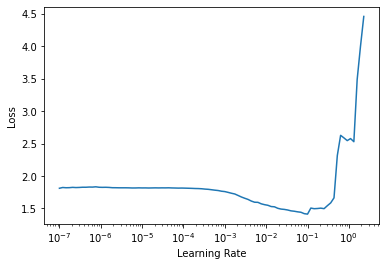

In [11]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy, cbs=WandbCallback())
lr = learn.lr_find()

In [12]:
lr

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.0964782238006592)

Here we define our training loop. We fit our model with the data loaders one cycle, and then loop through every series and create new training loaders every time to fit the next cycle.

In [0]:
def train_loop():
  learn.fit(1, lr.lr_steep)
  for sr in range(1, 8):
    for sj in range(2, 13):
      train = load_one_series(sj, sr)
      tr = TabularPandas(train, procs, [], cont_vars, y_names=dept_var, splits=None)
      trn_dl = TabDataLoader(tr.train, bs=64, shuffle=True, drop_last=True)
      learn.dls = DataLoaders(trn_dl, val_dl)
      learn.fit(1, lr.lr_steep)

In [18]:
train_loop()

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,time
0,0.850797,0.838730,0.817142,02:02


IndexError: ignored

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f6ca99eb378> (for post_run_cell):


NotebookValidationError: ignored

In [0]:
model = 'stage-1'

In [0]:
learn.save(model)
wandb.save(f'./model/{model}')

[]

In [0]:
learn.load(model)

## **Testing**
We're gonna download the testing data now from the Kaggle competition and unzip into the data directory.

In [0]:
!kaggle competitions download grasp-and-lift-eeg-detection -f test.zip

In [0]:
!unzip test.zip -d data/

Here we load the sample submission from the Kaggle competition. This gives us a prem-made dataframe and we just need to update column values with predictions from our model. 

In [0]:
test = pd.read_csv('sample_submission.csv')

In [0]:
test.loc[0]

id                    subj1_series9_0
HandStart                           0
FirstDigitTouch                     0
BothStartLoadPhase                  0
LiftOff                             0
Replace                             0
BothReleased                        0
Name: 0, dtype: object

Here we create a dataframe in the same shape as the example submission on the competition page.

In [0]:
path = './data/test'

def get_merged_tests():
  tests = None
  for sj in range(1, 13):
    for sr in range(9, 11):
      c_tests = pd.read_csv(f'{path}/subj{sj}_series{sr}_data.csv', dtype=feature_types)
      tests = c_tests if tests is None else tests.append(c_tests, ignore_index=True)
  for id in range(0, len(tests.index)):
    pred = classes[learn.predict(tests.loc[id])[1]]
    nl = '\n'
    log = f"Current pred: {pred}. Rows left to predict: {len(tests.index) - id}...{nl}"
    print(log)
    for col in test.keys():
      if col == pred:
        test.loc[id][col] = 1
      else:
        test.loc[id][col] = 0

In [0]:
get_merged_tests()

Current pred: None. Rows left to predict: 233081...

